In [1]:
import numpy as np
import h5py as hp
import sys

In [2]:
import PyHEADTAIL
import PyNAFF as pnf

PyHEADTAIL v1.14.1.22
(dirty git work tree)




In [3]:
from FITX import fit_risetime

In [4]:
from matplotlib import pyplot as plt
import seaborn as sbs
sbs.set(rc={'figure.figsize':(8.3,5.2),
            'text.usetex':True,
           'font.family':'serif',
           'font.size':20,
           'axes.linewidth':2,
           'lines.linewidth':3,
           'legend.fontsize':16,
           'legend.numpoints':1,},
        style='darkgrid',
        palette='colorblind',
        context='talk')

## Plots for single phase and different damping rates

In [5]:
def read_bunch_data(real, imag, folder):
#     filename_path = '/home/vgubaidulin/PhD/Data/Stability_scans/'+folder+'/'
    filename_path = '/home/vgubaidulin/PhD/Data_server/Stability_scans/FCC/'+folder+'/'
    postfix = '(dQre={0:.3f},dQim={1:.3f})'.format(real*1e3, imag*1e3)
    bunch_filename = filename_path+'BM'+postfix
    bunch_file = hp.File(bunch_filename+'.h5')
    mean_x = bunch_file['Bunch']['mean_x'][:]
    mean_xp = bunch_file['Bunch']['mean_xp'][:]
    epsn_x = bunch_file['Bunch']['epsn_x'][:]
    mean_y = bunch_file['Bunch']['mean_y'][:]
    mean_yp = bunch_file['Bunch']['mean_yp'][:]
    sigma_x = bunch_file['Bunch']['sigma_x'][:]
    sigma_y = bunch_file['Bunch']['sigma_y'][:]
    epsn_y = bunch_file['Bunch']['epsn_y'][:]
    n_turns = bunch_file['Bunch']['mean_x'].shape[0]
    bunch_file.close()
    return mean_x, mean_xp, sigma_x, mean_y, mean_yp, sigma_y, epsn_x, epsn_y, n_turns
def read_slice_data(real, imag, folder):
    filename_path = '/home/vgubaidulin/PhD/Data_server/Stability_scans/FCC/'+folder+'/'
    postfix = '(dQre={0:.3f},dQim={1:.3f})'.format(real*1e3, imag*1e3)
    slice_filename = filename_path+'slice_mon'+postfix
    slice_file = hp.File(slice_filename+'.h5')
#     print(slice_file.keys())
    slicewise_mean_x = slice_file['Slices']['mean_x'][:]*slice_file['Slices']['n_macroparticles_per_slice'][:]/n_macroparticles
    slicewise_mean_z = slice_file['Slices']['mean_z'][:]
    slice_file.close()
    return slicewise_mean_x, slicewise_mean_z

[-0.5 -0.4 -0.3 -0.2 -0.1  0.   0.1  0.2  0.3  0.4  0.5  0.6]
[0.   0.04 0.08 0.12 0.16 0.2  0.24 0.28 0.32]
Real coherent tune shift: -0.30e-3
Growth rate: -0.000
Growth rate: 0.040
Growth rate: 0.080
Growth rate: 0.120
Growth rate: 0.160
Growth rate: 0.200
Growth rate: 0.239
Growth rate: 0.279


/home/vgubaidulin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:40: RuntimeWarning: overflow encountered in true_divide
/home/vgubaidulin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: overflow encountered in square
/home/vgubaidulin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: overflow encountered in add


Growth rate: 0.319


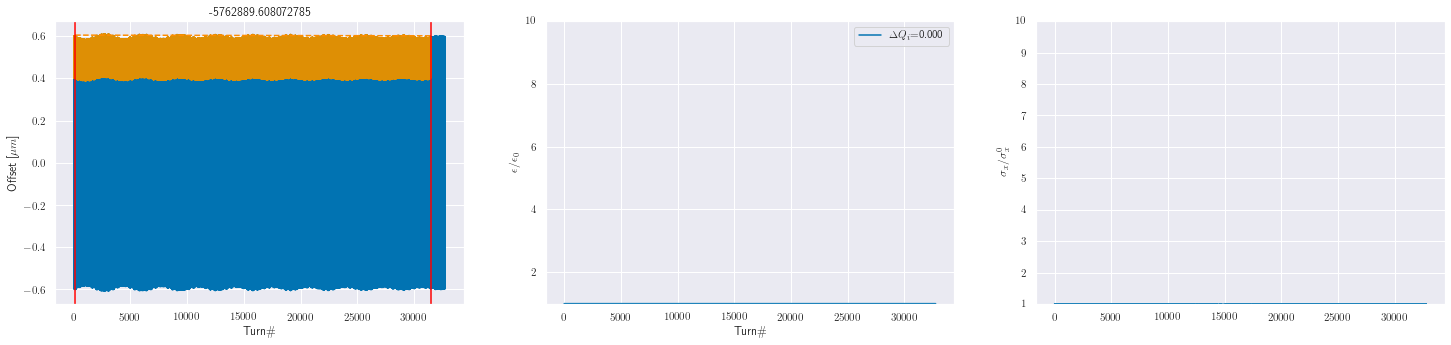

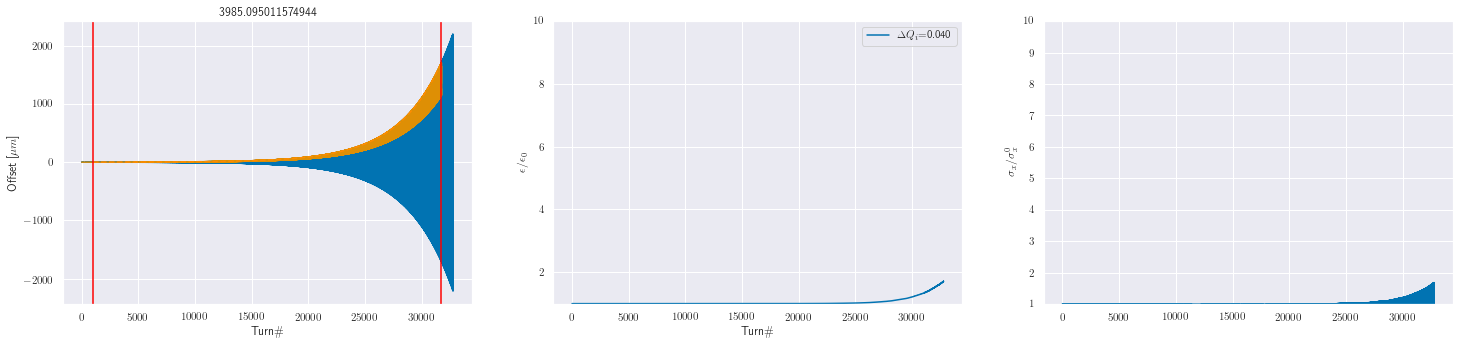

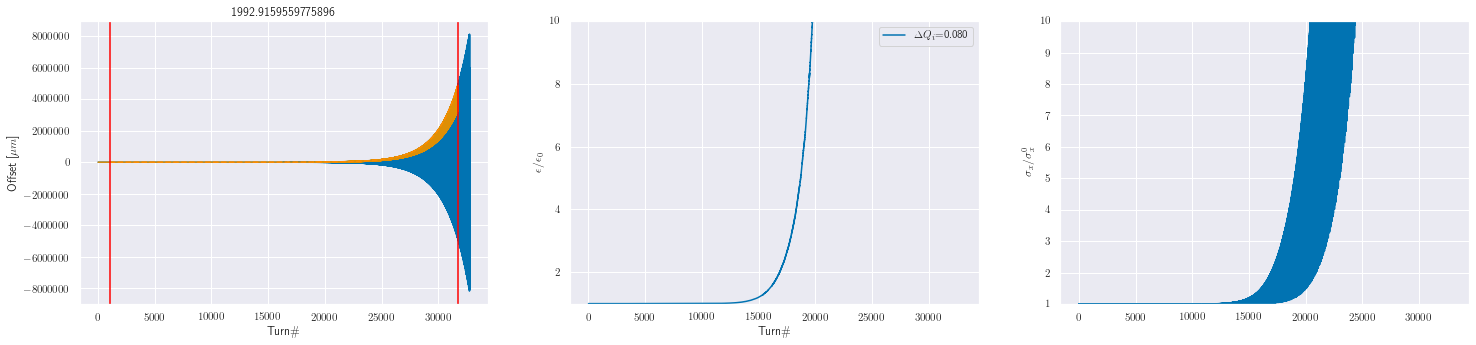

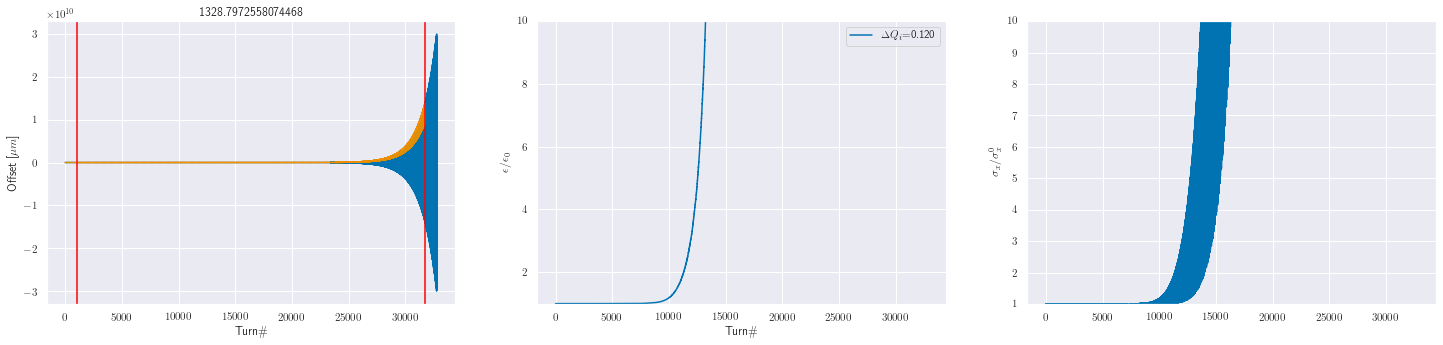

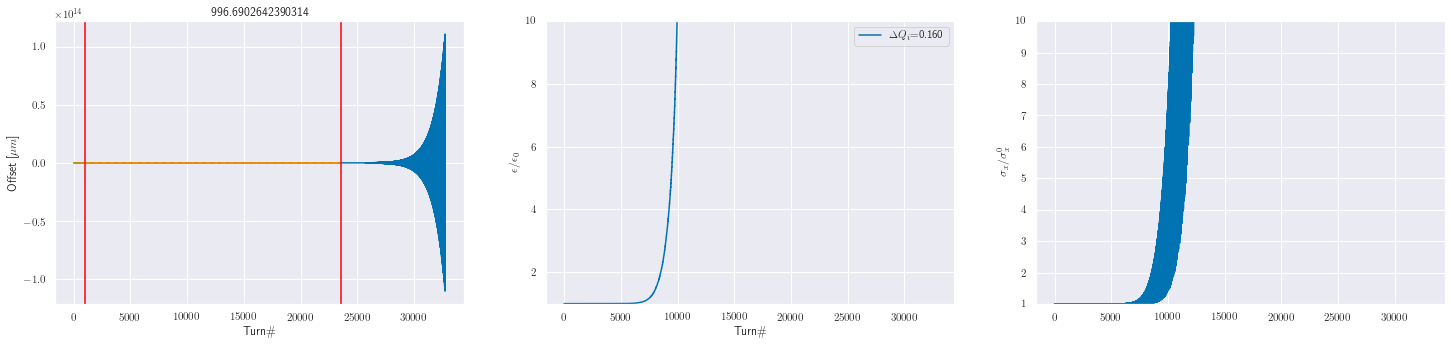

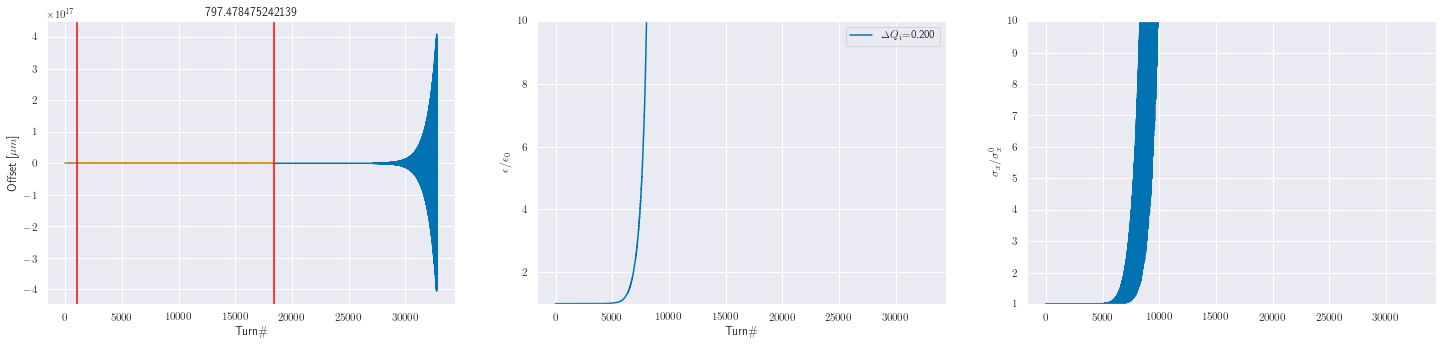

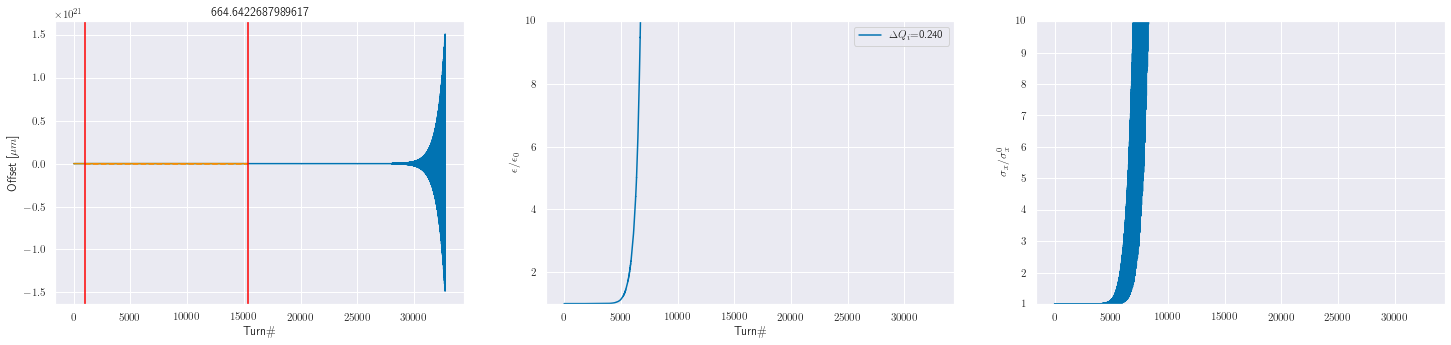

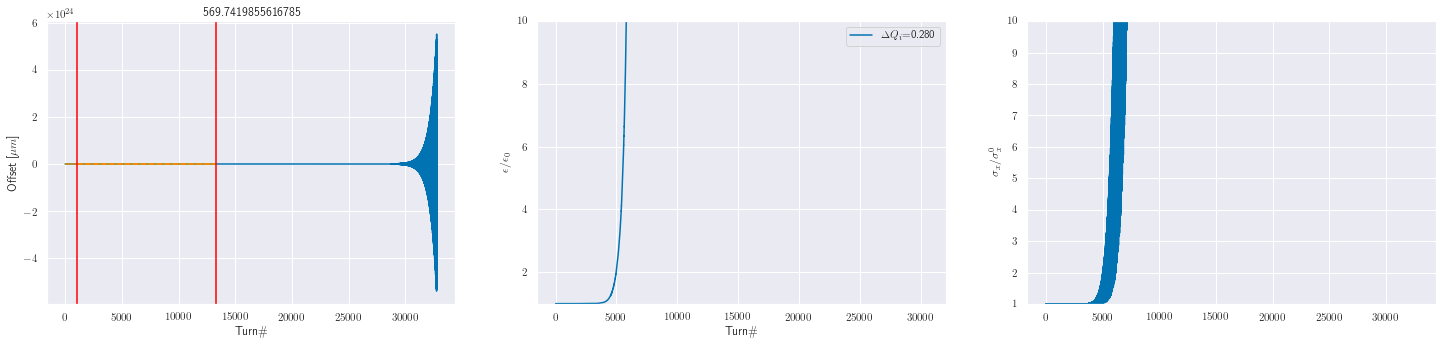

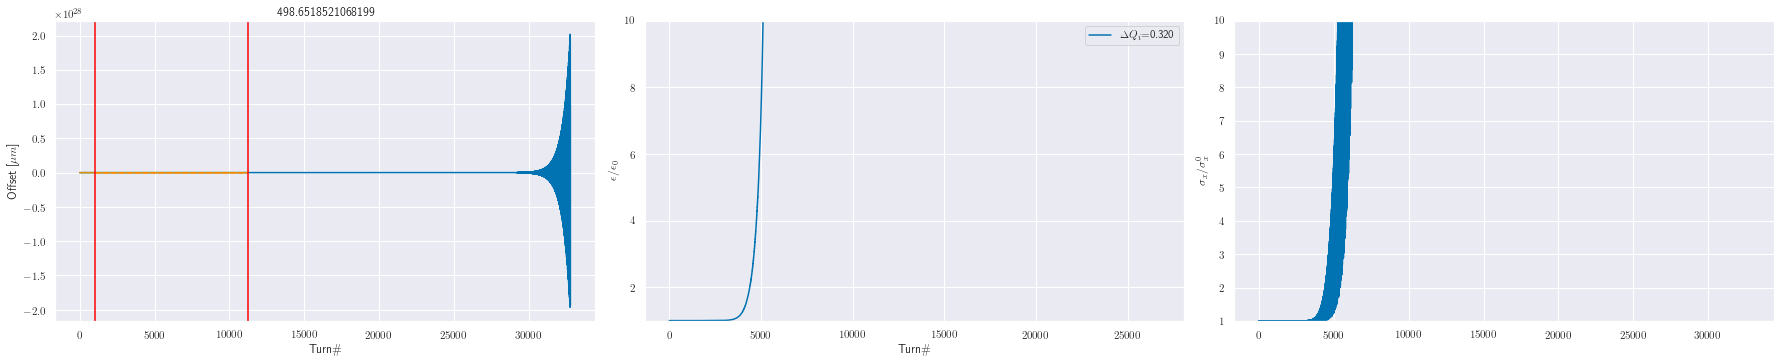

In [7]:
filename_path = '/home/vgubaidulin/PhD/Data_server/Stability_scans/FCC/'
sbs.set(rc={'figure.figsize':(3*8.3,5.2)})
folder = 'pelens2'
dQcoh_real = np.load(filename_path+folder+'/dQcoh_real.npy')[1:]
dQcoh_imag = np.load(filename_path+folder+'/dQcoh_imag.npy')
# dQcoh_imag = np.concatenate((np.load(filename_path+folder+'/dQcoh_imag.npy'), np.load(filename_path+folder+'/dQcoh_imag2.npy')[1:])) 
print(dQcoh_real/1e-3)
print(dQcoh_imag/1e-3)
sbs.set_palette('colorblind')
r = dQcoh_real[2]
print('Real coherent tune shift: {0:.2f}e-3'.format(r*1e3))
n_macroparticles = 16384
# numerical parameters
smoothing_window_size = 1024
growth_rates = []
tunes = []
for index, i in enumerate(dQcoh_imag):
    mean_x, mean_xp, sigma_x, mean_y, mean_yp, sigma_y, epsn_x, epsn_y, n_turns = read_bunch_data(r, i, folder)
    beta_x = 93.7
    beta_y = 92.6
    signal_x = 1e6*np.sqrt((mean_x)**2 + (beta_x * mean_xp)**2)
    index = np.where(signal_x < 1e10)[0][-1]
    signal_x = signal_x[:index]
    plt.subplots(1, 3)
    plt.subplot(131)
    plt.xlabel('Turn\#')
    plt.ylabel('Offset [$\mu m$]')
    plt.plot(range(n_turns), 1e6*mean_x)
    min_level = 5 * np.max(signal_x[:1000])
    rx = fit_risetime(
        signal_x, min_level=min_level, min_n_risetimes=1.5,
        smoothing_window_size=smoothing_window_size,
        matplotlib_axis=plt.gca(), start_from_0=True
    )
    if ( (not np.isnan(rx)) and (1/(2*np.pi*rx))>2e-5 ):
        growth_rates.append(1/(2*np.pi*rx))
        tunes.append(i)
    print('Growth rate: {0:.3f}'.format(1e3/(2*np.pi*rx)))
    plt.subplot(132)
    plt.plot(range((n_turns)), epsn_x/epsn_x[0])
    plt.ylim(0.99, 10.0)
    plt.xlabel('Turn\#')
    plt.ylabel(r'$\epsilon / \epsilon_0$')
    plt.legend((r'$\Delta Q_i$={0:.3f}'.format(i*1e3),))
    plt.subplot(133)
    plt.plot(range(n_turns), sigma_x/sigma_x[0])
    plt.ylabel(r'$\sigma_x/\sigma^0_x$')
    plt.ylim(1, 10)
plt.tight_layout()    
plt.show()

Stability boundary is at 0.000
R-squared score for the model is: 1.000


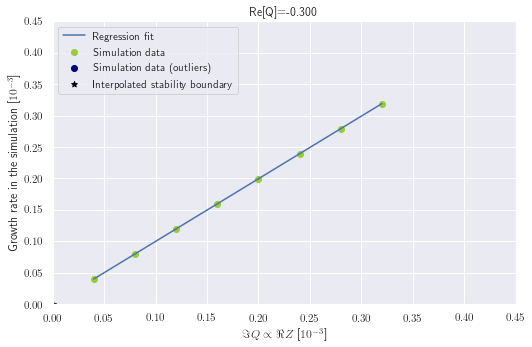

In [8]:
from sklearn.linear_model import RANSACRegressor, LinearRegression
from sklearn.metrics import r2_score
ransac = RANSACRegressor()
x = np.array(tunes).reshape(-1, 1)/1e-3
y = np.array(growth_rates)/1e-3
sbs.set(rc={'figure.figsize':(8.3,5.2)})
ransac.fit(x, y)
predicted_y = ransac.predict(x)
inlier_mask = ransac.inlier_mask_
outlier_mask = np.logical_not(inlier_mask)
plt.plot(x, predicted_y)
plt.scatter(x[inlier_mask], y[inlier_mask], marker='o', label='inliers', color='yellowgreen')
plt.scatter(x[outlier_mask], y[outlier_mask], marker='o', label='outliers', color='navy')

stability_boundary = -ransac.estimator_.intercept_/ransac.estimator_.coef_[0] if -ransac.estimator_.intercept_/ransac.estimator_.coef_[0] > 0 else 0
print(r'Stability boundary is at {0:.3f}'.format(stability_boundary))
r2 = r2_score(ransac.predict(x[inlier_mask]), y[inlier_mask])
print(r'R-squared score for the model is: {0:.3f}'.format(r2))
plt.scatter(stability_boundary, 0, marker='*', color='black')
plt.xlim(0, 0.45)
plt.ylim(0, 0.45)
plt.title('Re[Q]={0:.3f}'.format(r*1e3))
plt.ylabel('Growth rate in the simulation [$10^{-3}$]')
plt.xlabel(r'$\Im{Q}\propto\Re{Z}$ [$10^{-3}$]')
plt.legend(( 'Regression fit', 'Simulation data', 'Simulation data (outliers)','Interpolated stability boundary'), loc='upper left')
plt.show()

## Stability diagram reconstruction

In [8]:
folder = '/home/vgubaidulin/PhD/Data_server/Stability_scans/FCC/pelens/'
# folder = '/home/vgubaidulin/PhD/Data/Stability_scans/rfq_test/'
dQcoh_real = np.load(folder+'dQcoh_real.npy')
# dQcoh_imag = np.concatenate((np.load(folder+'dQcoh_imag.npy'), np.load(folder+'dQcoh_imag2.npy')[1:]))
dQcoh_imag = np.load(folder+'dQcoh_imag.npy')
n_macroparticles = 16384
# numerical parameters
smoothing_window_size = 512
def get_growth_rates(dQcoh_real, dQcoh_imag, folder):
    growth_rates = np.zeros(shape=(len(dQcoh_real), len(dQcoh_imag)), dtype=np.float64)
    tunes = np.zeros(shape=(len(dQcoh_real), len(dQcoh_imag)), dtype=np.float64)
    for r_index, r in enumerate(dQcoh_real):
        for i_index, i in enumerate(dQcoh_imag):
            mean_x, mean_xp, sigma_x, mean_y, mean_yp, sigma_y, epsn_x, epsn_y, n_turns = read_bunch_data(r, i, 'pelens')
            beta_x = 93.7
            beta_y = 92.6
            signal_x = 1e6*np.sqrt((mean_x)**2 + (beta_x * mean_xp)**2)
            index = np.where(signal_x < 1e10)[0][-1]
            signal_x = signal_x[:index]
            min_level = 5 * np.max(signal_x[:1000])
            rx = fit_risetime(
                signal_x, min_level=min_level, min_n_risetimes=1.5,
                smoothing_window_size=smoothing_window_size,
                matplotlib_axis=None,  
                start_from_0=True
            )
            if ( (not np.isnan(rx)) and rx > 0 and (1/(2*np.pi*rx)) > 1e-5):
                growth_rates[r_index, i_index] = 1/(2*np.pi*rx)
                tunes[r_index, i_index] = i
            else:
                growth_rates[r_index, i_index] = growth_rates[r_index, i_index-1]
                tunes[r_index, i_index] = tunes[r_index, i_index-1]
    return growth_rates, tunes
growth_rates, tunes = get_growth_rates(dQcoh_real, dQcoh_imag, folder)

/home/vgubaidulin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: overflow encountered in square
/home/vgubaidulin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: overflow encountered in add


R-squared score for real part of tune -0.600 is 1.00
R-squared score for real part of tune -0.500 is 1.00
R-squared score for real part of tune -0.400 is 0.87
R-squared score for real part of tune -0.300 is 1.00
R-squared score for real part of tune -0.200 is -42.00
R-squared score for real part of tune -0.100 is -42.00
R-squared score for real part of tune 0.000 is 1.00
R-squared score for real part of tune 0.100 is 0.99
R-squared score for real part of tune 0.200 is 0.98
R-squared score for real part of tune 0.300 is 0.98
R-squared score for real part of tune 0.400 is 0.96
R-squared score for real part of tune 0.500 is 0.96
R-squared score for real part of tune 0.600 is 1.00


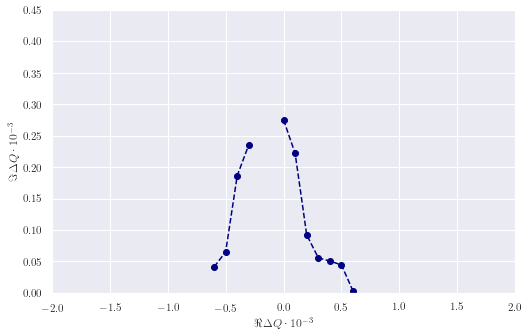

In [10]:
def get_stability_point(tunes, growth_rates):
    x = np.array(tunes).reshape(-1, 1)/1e-3
    y = np.array(growth_rates)/1e-3
    try:
        ransac = RANSACRegressor()
        x = x[y>1e-2]
        y = y[y>1e-2]
        ransac.fit(x, y)
        predicted_y = ransac.predict(x)
        inlier_mask = ransac.inlier_mask_
        outlier_mask = np.logical_not(inlier_mask)
        point = -ransac.estimator_.intercept_/ransac.estimator_.coef_[0]
        stability_boundary = point if point > 0 else 0
        r2 = r2_score(ransac.predict(x[inlier_mask]), y[inlier_mask])
    except:
        stability_boundary = None
        r2 = -42
    if r2 < 0.7 or ransac.estimator_.coef_[0] < 0:
        stability_boundary = None
    return stability_boundary, r2

stability_boundary = np.zeros(shape=(2, len(dQcoh_real)), dtype=np.float64)
for r_index, r in enumerate(dQcoh_real):
    Qs = tunes[r_index, :]
    grates = growth_rates[r_index, :] 
    i_index = np.where(grates > 0)[0]
    Qs = tunes[r_index, i_index]
    grates = growth_rates[r_index, i_index]
    stab_point, r2 = get_stability_point(Qs, grates)
    print('R-squared score for real part of tune {0:.3f} is {1:.2f}'.format(r*1e3, r2))
    stability_boundary[:, r_index] = r, stab_point
sbs.set(rc={'figure.figsize':(8.3,5.2)})
plt.plot(stability_boundary[0,:]/1e-3, stability_boundary[1,:], marker='o', color='navy', linestyle='--')
np.save('/home/vgubaidulin/PhD/Data/Stability_diagrams_from_simulation/pelens/dQre.npy', stability_boundary[0,:])
np.save('/home/vgubaidulin/PhD/Data/Stability_diagrams_from_simulation/pelens/dQim.npy', stability_boundary[1,:])
plt.xlim(-2.0, 2.)
plt.ylim(0, 0.45)
dQre = np.load('/home/vgubaidulin/PhD/Data/Stability_diagrams/octupoles/dQre.npy')
dQim = np.load('/home/vgubaidulin/PhD/Data/Stability_diagrams/octupoles/dQim.npy')
# plt.plot(dQre/1e-3, dQim/1e-3)
# dQ = 2*np.load('/home/vgubaidulin/PhD/Data/Stability_diagrams/rfq/horizontal.npy')
# plt.plot(np.real(dQ)/1e-3, np.imag(dQ)/1e-3)
plt.xlabel(u'$\Re{\Delta Q}\cdot 10^{-3}$')
plt.ylabel(u'$\Im{\Delta Q}\cdot 10^{-3}$')
plt.show()